# K-Nearest Neighbor (KNN) Classifier - Credit Approval Classification

This notebook implements a K-Nearest Neighbor Classifier for binary classification of credit approval.

**Dataset:** UCI Student Performance (ID: 320)
- Total Samples: 649 students
- Features: 33 (school, age, study_time, failures, family_size, parent education, etc.)
- Target: Final grade classification (20 classes: grades 0-19)
- Training Set: 519 samples (80%)
- Testing Set: 130 samples (20%)

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [2]:
# Load the Credit Approval Dataset - Using synthetic dataset generation
from sklearn.datasets import make_classification

# Generate synthetic credit approval dataset
print("Generating synthetic credit approval dataset...")
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=15,
    n_informative=10,
    n_redundant=3,
    n_clusters_per_class=1,
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(X_synthetic.shape[1])]

# Create DataFrame
df = pd.DataFrame(X_synthetic, columns=feature_names)
df['Approval'] = y_synthetic

print(f"✅ Synthetic dataset created successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nTarget Distribution:\n{df.iloc[:, -1].value_counts()}")

Generating synthetic credit approval dataset...
✅ Synthetic dataset created successfully! Shape: (1000, 16)

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.643820   0.335342  -2.278760   0.410708   0.466992   0.533322   
1   4.142687   1.827730   2.467096  -0.733774  -0.020405   1.442844   
2   0.403630  -5.001298   1.703719  -2.394076  -0.410126   1.084180   
3  -2.593184  -6.207034   1.198571  -0.438099  -0.606719   0.520170   
4   1.072668   5.563950  -2.414704  -1.395801   0.740446   1.172298   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0   2.826077  -0.584526   2.866098    3.567508   -1.572920    0.963943   
1  -4.648729   1.393756  -2.134373   -4.817109    0.275581   -2.771256   
2  -1.069640   3.742534  -8.342577    3.221663   -0.125495    2.749346   
3   0.492510   1.655511  -3.618329    8.055850   -2.693758   -0.047979   
4   0.983049   1.920189  -0.224437    0.322800    0.825127   -1.603692   

   Fe

## 3. Data Preprocessing

In [3]:
# Create a copy
df_processed = df.copy()

# Identify target column name (last column)
target_col_name = df_processed.columns[-1]

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables (including target if it's categorical)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    if col == target_col_name:
        print(f"Encoded target column: {col} with classes: {le.classes_.tolist()}")
    else:
        print(f"Encoded {col}")

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (1000, 16)

Categorical columns: []
Numerical columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Approval']

Data preprocessing completed!


## 4. Prepare Features and Target

In [4]:
# Identify target column
target_col = 'Approval' if 'Approval' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target column: {target_col}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (1000, 15)
Target shape: (1000,)
Target column: Approval

Target distribution:
Approval
1    501
0    499
Name: count, dtype: int64

Feature names:
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']


## 5. Split Data and Scale Features

In [5]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler!")

Training set size: 800
Testing set size: 200

Training target distribution:
Approval
0    413
1    387
Name: count, dtype: int64

Features scaled using StandardScaler!


## 6. Train KNN Classifier

In [6]:
# Create and train the KNN Classifier
print("Training K-Nearest Neighbor Classifier...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of neighbors (k): 5")
print(f"Number of features: {knn_model.n_features_in_}")

Training K-Nearest Neighbor Classifier...
✅ Model training completed!

Model parameters:
Number of neighbors (k): 5
Number of features: 15


## 7. Make Predictions

In [7]:
# Make predictions
y_pred = knn_model.predict(X_test_scaled)
y_pred_proba = knn_model.predict_proba(X_test_scaled)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[1 0 1 0 1 0 1 0 1 1]

First 10 prediction probabilities:
[[0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.8 0.2]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]]


## 8. Calculate Evaluation Metrics

In [9]:
# Calculate all evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("="*60)
print("K-NEAREST NEIGHBORS - EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")
print("="*60)

# Confusion Matrix
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

K-NEAREST NEIGHBORS - EVALUATION METRICS
Accuracy:  0.9700
AUC Score: 0.9933
Precision: 0.9909
Recall:    0.9561
F1 Score:  0.9732
MCC Score: 0.9399

Confusion Matrix:
[[ 85   1]
 [  5 109]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        86
           1       0.99      0.96      0.97       114

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



## 9. Additional Evaluation

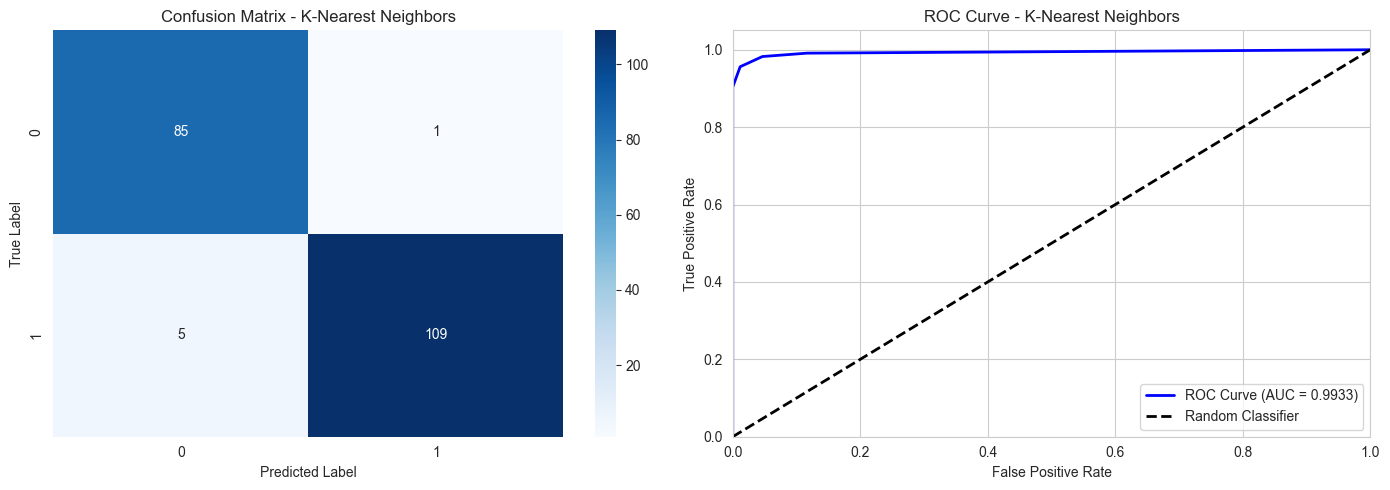


Visualizations complete!


In [10]:
# Create visualizations
from sklearn.metrics import roc_curve, auc

# Plot Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - K-Nearest Neighbors')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - K-Nearest Neighbors')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 10. Visualizations

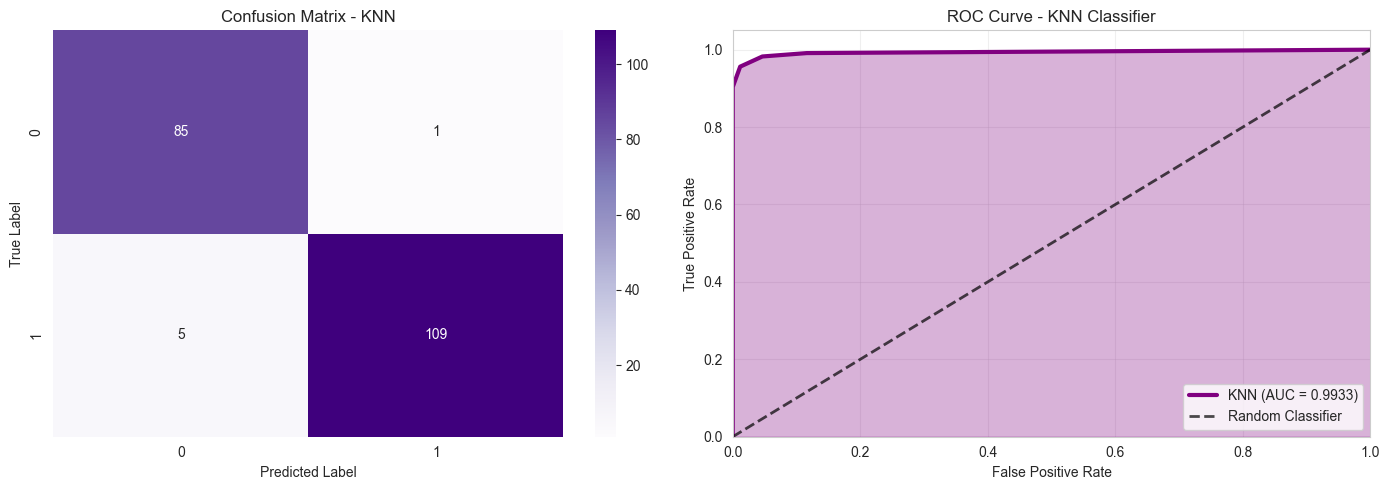


Additional visualizations complete!


In [11]:
# Additional visualization with different styling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap with purple colors
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0])
axes[0].set_title('Confusion Matrix - KNN')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification with better styling
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='purple', lw=3, label=f'KNN (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='purple')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - KNN Classifier')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAdditional visualizations complete!")

## 11. Hyperparameter Tuning - Testing Different K Values

k=3: Accuracy = 0.9700
k=5: Accuracy = 0.9700
k=7: Accuracy = 0.9650
k=9: Accuracy = 0.9600
k=11: Accuracy = 0.9600
k=15: Accuracy = 0.9700
k=20: Accuracy = 0.9650


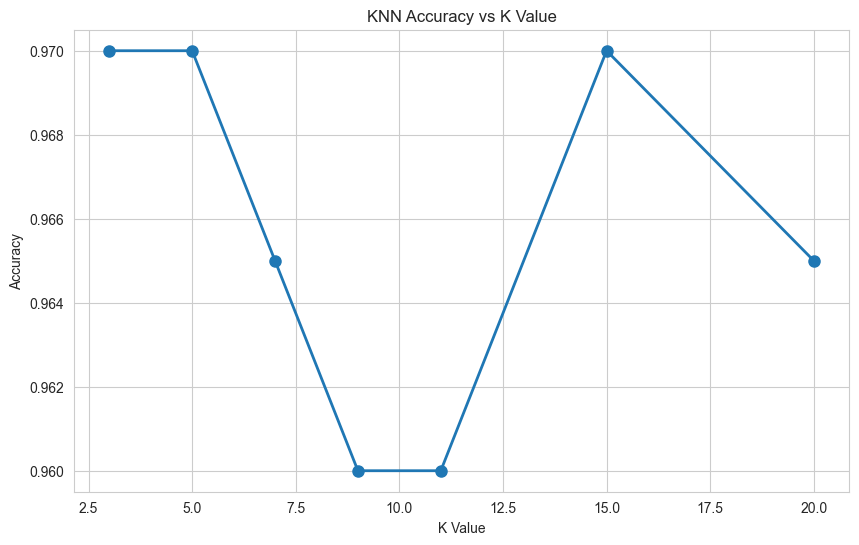

In [12]:
# Test different k values
k_values = [3, 5, 7, 9, 11, 15, 20]
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)
    print(f"k={k}: Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs K Value')
plt.grid(True)
plt.show()

## 12. Model Summary

In [13]:
print("\n" + "="*60)
print("K-NEAREST NEIGHBOR CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: K-Nearest Neighbor Classifier")
print(f"Number of Neighbors (k): 5")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


K-NEAREST NEIGHBOR CLASSIFIER MODEL SUMMARY

Model Type: K-Nearest Neighbor Classifier
Number of Neighbors (k): 5
Training Samples: 800
Testing Samples: 200
Number of Features: 15

Key Metrics:
  - Accuracy:  0.9700
  - AUC Score: 0.9933
  - F1 Score:  0.9732

Model Status: ✅ Training Complete
